In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator_psc import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption, regplot, scatterplot
import copy
from IPython.display import display
from collections import defaultdict
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import pathlib

from pandarallel import pandarallel

import dask.dataframe as dsk

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

In [3]:
def load_data(path):
    spikes_ex, spikes_in = [], []
    for f in path.iterdir():
        if f.suffix == '.gdf':
            df = dsk.read_csv(
                f, sep='\t', header=None).rename(columns={0:'sender', 1:'times'}).drop(columns=2)
            if f.stem.startswith('ex'):
                spikes_ex.append(df)

    spikes_ex = dsk.concat(spikes_ex)

    spikes_ex.compute()

    spiketrains_ex = spikes_ex.groupby('sender')

    stim_data = np.load(path / 'stimulation_data_0.npz', allow_pickle=True)['data'][()]
    stim_times = np.array(stim_data['times'])
#     stim_durations = np.array(stim_data['durations'])
    return spiketrains_ex, stim_times

In [55]:
def make_trials(stim_times, spikes, t1, t2):
    trials = []
    for i, t in enumerate(stim_times):
        idx = np.searchsorted(spikes, [t + t1, t + t2], side='right')
        trials.append(spikes[idx[0]: idx[1]] - t)
    return trials

In [56]:
def compute_stim_response(stim_times, spikes, x1, x2):
    stim_win = np.insert(
        stim_times + x1,
        np.arange(len(stim_times)) + 1,
        stim_times + x2)
    src_y = np.searchsorted(spikes, stim_win, side='right')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Y.astype(bool).astype(int)

In [139]:
def plot_density(trials, sigma, raster=False, shade=None, **kwargs):
    from scipy.stats import gaussian_kde
    spikes = [a for b in trials for a in b]
    kernel = gaussian_kde(spikes, sigma)
    times = np.arange(-4, 15, 0.01)
    plt.plot(times, kernel(times), **kwargs)
    
    if raster:
        trial_ids = [a for i, b in enumerate(trials) for a in [i] * len(b)]
        plt.scatter(spikes, trial_ids, s=1)
    if shade is not None:
        plt.axvspan(*shade, color='cyan', alpha=.3)
#         plt.axvspan(3, 8, color='r', alpha=.3)

In [170]:
z1=-3
z2=-1
x1=1
x2=3
y1=3
y2=7
yb1=-2
yb2=0

def compute_trials(spiketrains_ex, stim_times, A, C):
    A_spikes = np.sort(spiketrains_ex.get_group(A).times.compute().values)
    C_spikes = np.sort(spiketrains_ex.get_group(C).times.compute().values)

    C_trials = np.array(make_trials(stim_times, C_spikes, -5, 15))

    A_trials = np.array(make_trials(stim_times, A_spikes, -5, 15))

    Z = compute_stim_response(stim_times, A_spikes, z1, z2)
    X = compute_stim_response(stim_times, A_spikes, x1, x2)
    Y = compute_stim_response(stim_times, C_spikes, y1, y2)
    Yb = compute_stim_response(stim_times, C_spikes, yb1, yb2)
    
    return A_trials, C_trials, Z, X, Y, Yb

In [171]:
# base_path = pathlib.Path('/media/storage_hdd3T/causal_opto_data/container_results_branch')
base_path = pathlib.Path('/media/storage_hdd3T/causal_opto_data/container_results_branch_osc_poisson')

In [172]:
paths = sorted(
    [p for p in base_path.glob('results_*') if p.is_dir()], 
    key=lambda x: int(x.stem.split('_')[-1])
)

In [173]:
data = {}

In [174]:
# Connected
# A, C = 148, 934
# A, C = 1070, 2371

# Not connected
A, C = 1094, 885
# A, C = 2973, 489

pair = '{}-{}'.format(A,C)

In [175]:
for path in tqdm(paths[:30]):
    stem = path.stem
    if stem not in data:
        spiketrains_ex, stim_times = load_data(path)
        data[stem] = {
            'spiketrains_ex': spiketrains_ex,
            'stim_times': stim_times
        }
    else:
        spiketrains_ex = data[stem]['spiketrains_ex']
        stim_times = data[stem]['stim_times']
        
    if pair not in data[stem]:
        A_trials, C_trials, Z, X, Y, Yb = compute_trials(spiketrains_ex, stim_times, A, C)

        data[stem][pair] = {
            'A_trials': A_trials, 
            'C_trials': C_trials,
            'Z': Z, 
            'X': X, 
            'Y': Y,
            'Yb': Yb
        }

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

In [176]:
A_trials = np.concatenate([v[pair]['A_trials'] for v in data.values()])
C_trials = np.concatenate([v[pair]['C_trials'] for v in data.values()])
Z = np.concatenate([v[pair]['Z'] for v in data.values()])
X = np.concatenate([v[pair]['X'] for v in data.values()])
Y = np.concatenate([v[pair]['Y'] for v in data.values()])
Yb = np.concatenate([v[pair]['Yb'] for v in data.values()])

In [177]:
sum(Z==1)

3913

In [178]:
sum(Y==1)

121065

In [182]:
beta = Y[X==1].mean() - Y[X==0].mean()
beta_iv = (
    Y[(Z==0) & (X==1)].mean() - Y[(Z==1) & (X==0)].mean() + 
    Yb[(Z==0) & (X==1)].mean() - Yb[(Z==1) & (X==0)].mean()
)
print(beta, beta_iv)

0.08286112293396475 0.11943176290127586


Text(0.5,1,'beta_iv = 0.1260, beta = 0.0829')

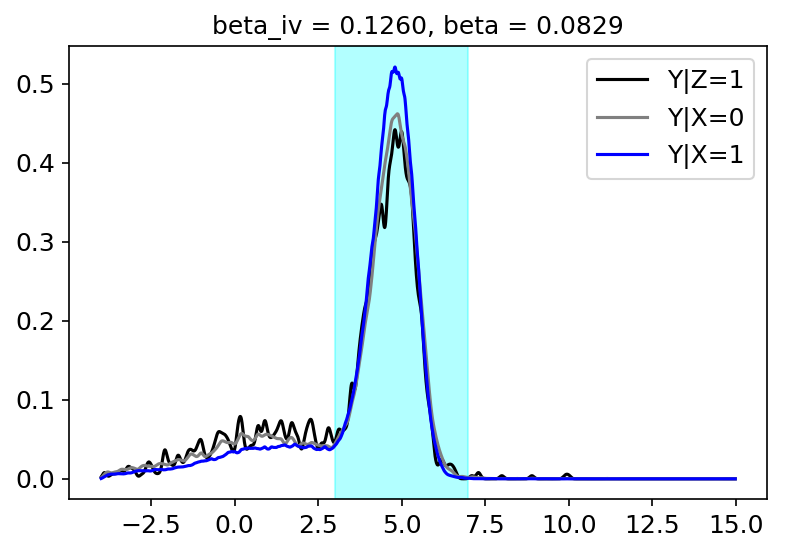

In [180]:
sigma = 0.03
plot_density(C_trials[Z==1], sigma, color='k', label='Y|Z=1')
plot_density(C_trials[X==0], sigma, color='grey', label='Y|X=0')
plot_density(C_trials[X==1], sigma, color='b', shade=[y1, y2], label='Y|X=1')
# plot_density(A_trials, 0.01, color='y', shade=[x1, x2], label='X')
plt.legend()
plt.title('beta_iv = {:.4f}, beta = {:.4f}'.format(beta_iv, beta))

In [157]:
# plot_density(
#     [c - a for c, a in zip(C_trials[Z==1], A_trials[Z==1]) if len(c) == len(a)], 
#     sigma, color='k', label='Y|Z=1')
# plot_density(
#     [c - a for c, a in zip(C_trials[X==0], A_trials[X==0]) if len(c) == len(a)], 
#     sigma, color='grey', label='Y|X=0')
# plot_density(
#     [c - a for c, a in zip(C_trials[X==1], A_trials[X==1]) if len(c) == len(a)], 
#     sigma, color='b', shade=[y1, y2], label='Y|X=1')
# plot_density(C_trials[X==1], sigma, color='b', ls='--', shade=[y1, y2], label='Y|X=1')
# plt.legend()